##This notebook deals with answering the following questions: 
1) Identifying putative attachment sites in dsDNA bacteriophage genomes  <br>
2) Characterizing their length distribution  <br>
3) Examining their sequence diversity

In [1]:
#This code is a staple of pretty much every notebook. The output of it is lengthData, which contains various 
#types of information (e.g. number of proteins genome length, host lineage, viral lineage, etc) for each virus. 
import numpy as np
import matplotlib.pyplot as plt
import ete3 as ete
import os
import Bio
import random
import scipy.stats as stats
from functools import *
from Bio import Entrez
from Bio import SeqIO
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import re
%matplotlib inline
sns.set_context("paper")

#as part of quality control the following viruses had to be omitted from our analysis
#they contain misannotations or mislabeled hosts, etc. 
badFolders = ['Acyrthosiphon_pisum_secondary_endosymbiont_phage_1_uid14047', 'Aureococcus_anophagefferens_virus_MM_2014_uid258005', 'Dragonfly_associated_microphage_1_uid177547', 'Enterobacter_phage_PG7_uid240014', 'Escherichia_phage_vB_EcoM_JS09_uid248321', 'Lactobacillus_phage_LL_H_uid19803', 'Providencia_phage_Redjac_uid177540', 'Pseudoalteromonas_phage_RIO_1_uid206039', 'Sputnik_virophage_2_uid243067', 'Sputnik_virophage_3_uid243065', 'Staphylococcus_phage_6ec_uid253318', 'Streptococcus_phage_DCC1738_uid253219', 'Streptococcus_phage_IC1_uid253220', 'Streptococcus_phage_K13_uid253223', 'Streptococcus_phage_SMP_uid18529', 'Vibrio_phage_CP_T1_uid181062', 'Vibrio_phage_vpms1_uid212709', 'Vibrio_phage_VPUSM_8_uid227006',  'Abaca_bunchy_top_virus_uid28697','Shallot_yellow_stripe_virus_uid15745','Equine_rhinitis_A_virus_uid15205','African_pouched_rat_arterivirus_uid274797','Spilanthes_yellow_vein_virus_uid19779', 'Velvet_bean_severe_mosaic_virus_uid41175','Paramecium_bursaria_Chlorella_virus_FR483_uid18305','Human_endogenous_retrovirus_K113_uid222261','Acholeplasma_phage_MV_L1_uid14573']
#viruses whose lineage is improperly annotated (they don't belong to any Baltimore group)
unknowns= ['Bacillus_phage_phBC6A51_uid15021', 'Bacillus_phage_phBC6A52_uid15022', 'Badger_feces_associated_gemycircularvirus_uid281125', 'Chaetoceros_DNA_virus_7_uid237558', 'Chaetoceros_lorenzianus_DNA_Virus_uid63565', 'Chaetoceros_tenuissimus_DNA_virus_uid60753', 'Cladosporium_cladosporioides_virus_1_uid258308', 'Enterobacteria_phage_YYZ_2008_uid32231', 'European_mountain_ash_ringspot_associated_virus_uid39973', 'Faecal_associated_gemycircularvirus_3_uid268557', 'Faecal_associated_gemycircularvirus_4_uid268556', 'Faecal_associated_gemycircularvirus_5_uid268555', 'Faecal_associated_gemycircularvirus_6_uid268554', 'Faecal_associated_gemycircularvirus_7_uid268553', 'Gentian_ovary_ring_spot_virus_uid256090', 'Geobacillus_virus_E2_uid19797', 'Glossina_pallidipes_salivary_gland_hypertrophy_virus_uid28839', 'Haloarcula_hispanica_icosahedral_virus_2_uid109269', 'Haloarcula_phage_SH1_uid15535', 'Halovirus_PH1_uid196975', 'Halovirus_VNH_1_uid262927', 'Human_genital_associated_circular_DNA_virus_1_uid281399', 'Lactobacillus_johnsonii_prophage_Lj771_uid28145', 'Magnaporthe_oryzae_RNA_virus_uid272442', 'Mongoose_feces_associated_gemycircularvirus_a_uid281407', 'Mongoose_feces_associated_gemycircularvirus_b_uid281406', 'Mongoose_feces_associated_gemycircularvirus_c_uid281404', 'Mongoose_feces_associated_gemycircularvirus_d_uid281405', 'Mycoplasma_phage_phiMFV1_uid14387', 'Penicillium_roqueforti_dsRNA_mycovirus_1_uid258162', 'Phage_Gifsy_1_uid32269', 'Phage_Gifsy_2_uid32271', 'Pigeonpea_cryptic_virus_uid244664', 'Planaria_asexual_strain_specific_virus_like_element_type_1_uid14140', 'Pseudomonas_phage_phi_Pto_bp6g_uid240724', 'Rhizoctonia_fumigata_mycovirus_uid283068', 'Rhodococcus_phage_REQ2_uid81171', 'Rhodococcus_phage_REQ3_uid81175', 'Rose_rosette_virus_uid64937', 'Rosellinia_necatrix_fusarivirus_1_uid255787', 'Rosellinia_necatrix_megabirnavirus_1_W779_uid41609', 'Salisaeta_icosahedral_phage_1_uid167575', 'Salmonella_phage_Fels_1_uid29267', 'Sodalis_phage_phiSG1_uid16583', 'Staphylococcus_phage_phi2958PVL_uid32173', 'Staphylococcus_phage_tp310_1_uid20659', 'Staphylococcus_phage_tp310_3_uid20663', 'Stenotrophomonas_phage_phiSMA9_uid15493', 'Streptococcus_phage_20617_uid239271', 'Streptococcus_phage_phiBHN167_uid227353', 'Streptococcus_pyogenes_phage_315_1_uid14533', 'Streptococcus_pyogenes_phage_315_2_uid14528', 'Streptococcus_pyogenes_phage_315_3_uid14529', 'Streptococcus_pyogenes_phage_315_4_uid14530', 'Streptococcus_pyogenes_phage_315_5_uid14531', 'Streptococcus_pyogenes_phage_315_6_uid14532', 'Tanay_virus_uid246129', 'Thermococcus_prieurii_virus_1_uid84407', 'Thermus_phage_IN93_uid14235', 'Thermus_phage_P23_77_uid40235']
badFolders=badFolders+unknowns
#these are satellite viruses 
sats = ['Ageratum_conyzoides_associated_symptomless_alphasatellite_uid259293', 'Ageratum_enation_alphasatellite_uid181994', 'Ageratum_leaf_curl_betasatellite_uid195929', 'Ageratum_leaf_curl_Cameroon_betasatellite_uid36669', 'Ageratum_yellow_leaf_curl_betasatellite_uid14439', 'Ageratum_yellow_vein_China_alphasatellite_uid237561', 'Ageratum_yellow_vein_China_virus_associated_DNA_beta_uid15515', 'Ageratum_yellow_vein_Singapore_alphasatellite_uid14232', 'Ageratum_yellow_vein_virus_satellite_DNA_beta_uid14444', 'Alternanthera_yellow_vein_virus_satellite_DNA_beta_uid19833', 'Andrographis_yellow_vein_leaf_curl_betasatellite_uid243492', 'Bhendi_yellow_vein_India_betasatellite__India_Aurangabad_OY164_2006__uid61557', 'Bhendi_yellow_vein_mosaic_betasatellite__India_Coimbator_OYCO1_2005__uid61777', 'Bhendi_yellow_vein_mosaic_virus_associated_alphasatellite_uid174781', 'Bhendi_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14445', 'Black_medic_leafroll_alphasatellite_1_uid243500', 'Cardamom_bushy_dwarf_virus_satellite_uid230064', 'Cassava_mosaic_Madagascar_alphasatellite_uid175666', 'Chili_leaf_curl_Bhatinda_betasatellite_uid206467', 'Chilli_leaf_curl_alphasatellite_uid253224', 'Chilli_leaf_curl_Multan_alphasatellite_uid39933', 'Chilli_leaf_curl_virus_satellite_DNA_beta_uid14441', 'Cleome_leaf_crumple_virus_associated_DNA_1_uid60045', 'Corchorus_yellow_vein_mosaic_betasatellite_uid192608', 'Cotton_leaf_curl_Burewala_alphasatellite_uid45935', 'Cotton_leaf_curl_Burewala_betasatellite_uid45933', 'Cotton_leaf_curl_Gezira_alphasatellite_uid42507', 'Cotton_leaf_curl_Gezira_virus_satellite_DNA_beta_uid15166', 'Cotton_leaf_curl_Multan_betasatellite_uid15780', 'Cotton_leaf_curl_virus_associated_DNA_1_isolate_Lucknow_uid65305', 'Cotton_leaf_curl_virus_associated_DNA_beta_uid14438', 'Cotton_leaf_curl_virus_betasatellite_uid162497', 'Cowpea_severe_leaf_curl_associated_DNA_beta_uid15157', 'Croton_yellow_vein_mosaic_alphasatellite_uid45931', 'Croton_yellow_vein_mosaic_betasatellite_uid18249', 'Cuban_alphasatellite_1_uid210798', 'Dragonfly_associated_alphasatellite_uid181244', 'Emilia_yellow_vein_virus_associated_DNA_beta_uid37893', 'Erectites_yellow_mosaic_virus_satellite_DNA_beta_uid19827', 'Eupatorium_yellow_vein_virus_satellite_DNA_beta_uid14447', 'Faba_bean_necrotic_stunt_alphasatellite_1_uid243499', 'Faba_bean_necrotic_stunt_alphasatellite_2_uid243498', 'French_bean_leaf_curl_betasatellite_Kanpur_uid169556', 'Gossypium_darwinii_symptomless_alphasatellite_uid39593', 'Gossypium_davidsonii_symptomless_alphasatellite_uid39589', 'Gossypium_mustilinum_symptomless_alphasatellite_uid39591', 'Grapevine_satellite_virus_uid208539', 'Guar_leaf_curl_alphasatellite_uid193981', 'Hedyotis_uncinella_yellow_mosaic_betasatellite_uid230991', 'Honeysuckle_yellow_vein_mosaic_disease_associated_satellite_DNA_beta_uid19863', 'Honeysuckle_yellow_vein_mosaic_virus_satellite_DNA_beta_uid14620', 'Leucas_zeylanica_yellow_vein_virus_satellite_DNA_beta_uid41305', 'Ludwigia_leaf_distortion_betasatellite__India_Amadalavalasa_Hibiscus_2007__uid29233', 'Ludwigia_yellow_vein_virus_associated_DNA_beta_uid15561', 'Luffa_puckering_and_leaf_distortion_associated_betasatellite__India_Gurdaspur_Okra_2013__uid253218', 'Luffa_puckering_and_leaf_distortion_associated_DNA_beta_uid15779', 'Malachra_yellow_vein_mosaic_virus_associated_satellite_DNA_beta_uid28727', 'Malvastrum_leaf_curl_betasatellite_uid16301', 'Malvastrum_leaf_curl_Guangdong_betasatellite_uid243827', 'Malvastrum_yellow_vein_Yunnan_virus_satellite_DNA_beta_uid14567', 'Melon_chlorotic_mosaic_virus_associated_alphasatellite_uid51413', 'Mesta_yellow_vein_mosaic_virus_alphasatellite__India_Hoshiarpur_Okra_2013__uid253217', 'Mesta_yellow_vein_mosaic_virus_associated_alphasatellite_uid174780', 'Mesta_yellow_vein_mosaic_virus_associated_DNA_beta_uid21015', 'Milk_vetch_dwarf_C10_alphasatellite_uid240682', 'Mirabilis_leaf_curl_India_virus_associated_betasatellite_uid255800', 'Mungbean_yellow_mosaic_India_virus_associated_betasatellite__India__Faizabad__Cow_Pea_2012__uid177773', 'Nanovirus_like_particle_uid14386', 'Okra_enation_leaf_curl_betasatellite__India_Sonipat_EL10_2006__uid61781', 'Okra_leaf_curl_Mali_virus_satellite_DNA_beta_uid20323', 'Okra_yellow_vein_disease_associated_sequence_uid14443', 'Olive_viral_satellite_RNA_uid230268', 'Papaya_leaf_curl_alphasatellite_uid233414', 'Papaya_leaf_curl_China_virus_satellite_DNA_beta_uid19819', 'Pepper_leaf_curl_virus_satellite_DNA_beta_uid28283', 'Pepper_leaf_curl_Yunnan_virus_satellite_DNA_beta_uid29415', 'Potato_apical_leaf_curl_disease_associated_satellite_DNA_beta_uid18323', 'Radish_leaf_curl_virus_betasatellite_uid28281', 'Sida_leaf_curl_virus_satellite_DNA_beta_uid19823', 'Sida_yellow_mosaic_virus_China_associated_DNA_beta_uid15514', 'Sida_yellow_vein_China_alphasatellite_uid238950', 'Siegesbeckia_yellow_vein_virus_associated_DNA_beta_uid17269', 'Subterranean_clover_stunt_C6_alphasatellite_uid14180', 'Synedrella_leaf_curl_alphasatellite_uid263034', 'Tobacco_leaf_chlorosis_betasatellite_uid178075', 'Tobacco_leaf_curl_disease_associated_sequence_uid14442', 'Tobacco_leaf_curl_PUSA_alphasatellite_uid56023', 'Tobacco_leaf_curl_virus_associated_DNA_beta_uid45925', 'Tomato_leaf_curl_Bangladesh_betasatellite_uid56017', 'Tomato_leaf_curl_Gandhinagar_betasatellite_uid231683', 'Tomato_leaf_curl_Hajipur_betasatellite_uid175587', 'Tomato_leaf_curl_Joydebpur_virus_satellite_DNA_beta_uid28273', 'Tomato_leaf_curl_Karnataka_alphasatellite_uid181995', 'Tomato_leaf_curl_Pakistan_virus_associated_DNA_1_uid38463', 'Tomato_leaf_curl_Patna_betasatellite_uid36541', 'Tomato_leaf_curl_Togo_betasatellite_Togo_2006__uid60629', 'Tomato_leaf_curl_Yemen_betasatellite_uid177643', 'Tomato_yellow_leaf_curl_China_betasatellite_uid181248', 'Tomato_yellow_leaf_curl_Vietnam_virus_satellite_DNA_beta_uid19829', 'TYLCCNV_Y322__satellite_DNA_beta_uid16338', 'Vernonia_yellow_vein_betasatellite_uid41303', 'Vernonia_yellow_vein_Fujian_virus_alphasatellite_uid72145', 'Vernonia_yellow_vein_Fujian_virus_betasatellite_uid72143', 'Zinnia_leaf_curl_disease_associated_sequence_uid14440', 'Zinnia_leaf_curl_virus_associated_DNA_beta_uid14538']


def getTaxidFromGenomeFolder(genome_folder):
    '''
    Takes an rpt file for a genome and returns the taxid in it.
    '''   
    if folder not in badFolders and folder not in sats:
        with open(os.path.join('all_rpt', folder, os.listdir(os.path.join('all_rpt', folder))[0])) as rpt_file:
            for line in rpt_file:
                if line.startswith('Taxid: '):
                    return int(line[7:-1])
                

def getHostTaxidFromGenomeFolder(genome_folder):
    '''
    Takes a folder containing an asn file and returns the taxid of the host of
    the virus described by that asn file.
    '''
    if folder not in badFolders and folder not in sats :
        with open('folderToHostTaxid.txt', 'r') as taxid2host:
            for line in taxid2host:
                if genome_folder in line:
                    return int(line.split('\t')[1][:-1])
        return 0
    

def getGenomeLengthFromGenomeFolder(genome_folder):
    total = 0
    if folder not in badFolders and folder not in sats :
        for file in os.listdir(os.path.join('all_ptt', folder)):
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                index = line.find('- 1..')
                if index == -1:
                    return -1
                num = line[index + 5 : -1]
                total += int(num)
        return total

    
def getProteinSeqsForEachVirus(folder):    
    for file in os.listdir(os.path.join('all_faa', folder)):  
        #these folders contain genomes with misannotation of gene overlap,non-coding DNA, or host information from NCBI. 
        if folder not in badFolders and folder not in sats :
            #opening a file to hold the protein sequences for each virus so I can BLASTX them later. 
            filename = folder + '_phageProteins'
            inputFileNameTXT = filename + '.txt'
            fo = open(inputFileNameTXT, 'w')
            with open(os.path.join('all_faa', folder, file)) as faa_file:
                for line in faa_file:
                    fo.write(line +'\n')
                fo.close()
    return 0
 

def getProtienNamesFromGenomeFolder(folder):
    protVec=[]
    for file in os.listdir(os.path.join('all_ptt', folder)):
        #these folders contain genomes with misannotation of gene overlap, non-coding DNA, or host information from NCBI. 
        if folder not in badFolders and folder not in sats:
            with open(os.path.join('all_ptt', folder, file)) as ptt_file:
                line = ptt_file.readline()
                line = ptt_file.readline()
                line = ptt_file.readline()               
                for line in ptt_file:                    
                    #this is to collect the name of proteins from ptt files                   
                    protVec.append(line.split('\t')[-1].rstrip())                                    
    return (protVec)
            
genomeLengths = []
lengthData = []
counter = 0
length_lists = []
hostTaxidList = []
taxidList = []
folders = []
proteinNames=[]
dbObject = ete.NCBITaxa()

for folder in os.listdir('all_faa'):
    #these entries had problems with their gene overlap, protein, and noncoding annotation, need to be excluded    
    if folder not in badFolders and folder not in sats :   
        length_lists.append([])
        for fileName in os.listdir(os.path.join('all_faa', folder)):
            with open(os.path.join('all_faa', folder, fileName), 'r') as faa_file:
                proteins = SeqIO.parse(faa_file, 'fasta')
                for protein in proteins:
                    length_lists[counter].append(float(len(protein.seq)))

        hostTaxid = getHostTaxidFromGenomeFolder(folder)

        # viruses with unidentified hosts. Now they are out. 
        if hostTaxid and hostTaxid != 11086 and hostTaxid != 10036 and hostTaxid != 37965 and hostTaxid != 10640  and hostTaxid != 32644 and hostTaxid != 1 and hostTaxid != 212035 and hostTaxid != 1051671:
            taxidList.append(getTaxidFromGenomeFolder(folder))
            hostTaxidList.append(hostTaxid)
            genomeLengths.append(getGenomeLengthFromGenomeFolder(folder))
            folders.append(folder)
            proteinNames.append(getProtienNamesFromGenomeFolder(folder))

            counter += 1
        else:
            length_lists = length_lists[:-1]

        #Uncomment the following lines to see the code's progress while its running        
        """
        if counter % 100 == 0:
            print(str(int(np.round(float(counter) * 100.0 / 2701.0))) + '% done.')
        """

taxidLineages = [dbObject.get_lineage(t) for t in taxidList]
englishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)]
                   for lin in taxidLineages]
hostTaxidLineages = [dbObject.get_lineage(t) for t in hostTaxidList]
hostEnglishLineages = [[str(rank) for rank in dbObject.translate_to_names(lin)] 
                       for lin in hostTaxidLineages]

for i in range(len(length_lists)):
    lengthData.append({'length_list' : length_lists[i],
                       'taxid' : taxidList[i],
                       'hostTaxid' : hostTaxidList[i],
                       'englishLineage' : englishLineages[i],
                       'taxidLineage' : taxidLineages[i],
                       'hostEnglishLineage' : hostEnglishLineages[i],
                       'hostTaxidLineage' : hostTaxidLineages[i],
                       'mean' : np.mean(length_lists[i]),
                       'std' : np.std(length_lists[i]),
                       'median' : np.median(length_lists[i]),
                       'numProteins' : len(length_lists[i]),
                       'proteinNames': proteinNames[i],
                       'genomeLength' : genomeLengths[i],
                       'folder' : folders[i]})
                       
lengthData = [virus for virus in lengthData if virus['genomeLength'] != -1]



/Users/Gita/anaconda/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


###Identifying the attachment sites in phage genomes

In [5]:
#In order to use PHASTER program to identify the attachment sites in a phage genome, 
#I used the URL API which takes in accession numbers for each phage genome. 
#I have the taxids for genomes, rather than their accessions, which the PHASTER program 
#doesn't recognize. So I downlowded a file from NCBI summarizing the genome names and their 
#accessions for dsDNA viruse of bacteria (downloaded Jan 2018). This file is 
#called "accPhages.txt". I'm going to capture phage genome accessions by matching the 
#phage names I have to those in accPhages.txt 

with open('accPhages.txt') as file:
    #reading the file as a dataframe
    allPhageDf=pd.read_table(file, sep='\t', names = ["Genome","Accession",'Source information',
                                                      'Number of segments','Genome length',
                                                      'Number of proteins','Genome Neighbors',
                                                      'Host','Date completed','Date updated'])
    allPhageDf.drop(0, inplace=True)
    allPhageDf.drop(1, inplace=True)
#getting the phage names from the version of the database I have been working with 
phageNames= [virus['englishLineage'][-1] for virus in lengthData if 'Bacteria' in 
                      virus['hostEnglishLineage'] and 'dsDNA viruses, no RNA stage' 
             in virus['englishLineage']]

#getting the phage names (and their accessions) whose names appear in my list (phageNames)
indexList=[]
for name in phageNames: 
    for index, row in allPhageDf.iterrows():
        if row['Genome']==name: 
            indexList.append(index)
            break
    
phageAccDf = allPhageDf.iloc[indexList]
#now let's get the accession column from phageAccDf and turn it into a list of accession numbers
accList=phageAccDf['Accession'].tolist()

###Creating a dataframe that contains attachment site info + other useful information

In [8]:
#With the detailed reports for the phages (164) that have predicted attachment sites, 
#let's create a dataframe that contains the accession numbers, as well as attachment 
#site sequences and locations 
filepath='attSitePosDetail1/'

dfAttAll=[]
for filename in os.listdir(filepath):     
    with open(os.path.join(filepath, filename)) as file:
        #creating a dataframe from each text file
        df=pd.read_table(file, sep='\t', names = ['desc'])
        #figuring out which row in each dataframe contains the attL and attR attachment sites,
        #and creating a seperate dataframe based on just those rows 
        #(in a way, we're filtering all irrelevant data in detailed reports)
        dfAttL=df[df['desc'].str.contains('attL')]
        #then spliting the row so I can seperate out the pertinant information
        #note if there are two rows containing attL, only information about the first row
        #is getting collected because I just want one instance of attL (or attR), 
        #I will get rid of other entries that will appear as duplicates
        splitL=dfAttL.iloc[0].str.split( )[0]
        #this will give the location of attachment site (attL)
        dfAttL['loc']=splitL[0]
        #this will output attL or attR
        dfAttL['att']=splitL[1]
        #this will give the nucleotide sequence for the attachment site
        dfAttL['seq']=splitL[3]
        
        #basically these following lines mimic the ones above but are for the attR 
        #region rather than attL
        dfAttR=df[df['desc'].str.contains('attR')]
        splitR=dfAttR.iloc[0].str.split( )[0]
        dfAttR['loc']=splitR[0]
        dfAttR['att']=splitR[1]
        dfAttR['seq']=splitR[3]

        #joining the two dataframes associated with attL and attR
        dfAtt=pd.concat([dfAttL,dfAttR])
        #getting the phage accession number used in PHASTER, which is part of the filename
        dfAtt['acc in PHASTER'] =filename[0:11]
        #getting the NCBI accession number, which is basically the same, 
        #but doesn't include trailing .1 or .2 
        dfAtt['acc'] =filename[0:9]

    #appending and concatenating dataframes for all phages that had attachment sites    
    dfAttAll.append(dfAtt)
dfAttAll =pd.concat(dfAttAll)
#let's drop the desc column since it doesn't contain any additional information
dfAttAll=dfAttAll.drop('desc', axis=1) 


#merging the two dataframe based on their shared accession columns (called by different names)
#allPhageDf is based on data downloaded for all dsDNA bacterial viruses from NCBI
#dfAttAll contains attachment site information for phages that were shown to have them after 
#being run through PHASTER program
mergedAtt = pd.merge(left=allPhageDf,right=dfAttAll, left_on='Accession', right_on='acc')

mergedAtt=mergedAtt.drop(['Number of segments','Source information','Genome Neighbors', 'Host'],
                         axis=1)

#getting rid of the duplicates (they represnt phages with multiple predicted attL or 
#attR sites, because I just want one instance 
#(there are 14 duplicates that were removed overall)
mergedAttNew=mergedAtt.drop_duplicates(subset=None, keep='first', inplace=False)

#now I also want to add host information and other useful stuff to the mergedAttNew dataframe
topHmod=topH[['virusTaxid','virusInfo','hostTaxid','hostInfo', 
              'condensedHostInfo','hostSpecies']]
#reducing the topHmod to have one representative row for each virus 
#(as of now each row is a protein)
topHunique=topHmod.drop_duplicates(subset='virusInfo', keep='first', inplace=False)

#trying to merge the two dataframes, based on the virus name (i.e virusInfo), 
#which is called differently in each dataframe
mergedAttPhageInfo = pd.merge(left=topHunique, right=mergedAttNew, 
                              how='right', left_on='virusInfo', right_on='Genome')
#modifying the loc column from its current format begining..end to [begining, end]
mergedAttPhageInfo['loc']=[x.split('..') for x in mergedAttPhageInfo['loc'].tolist()]
#modifying the Genome column so it doesn't include 
mergedAttPhageInfo['Genome length (nt)']=mergedAttPhageInfo[
    'Genome length'].str.replace(' nt','').astype(int)
mergedAttPhageInfo=mergedAttPhageInfo.drop(['Genome length'], axis=1)
mergedAttPhageInfo[['Accession', 'virusInfo']]

/Users/Gita/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Gita/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Gita/anaconda/lib/python3.4/site-packages/IPython/kernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

,Accession,virusInfo
0,NC_006557,Bacillus phage BCJA1c
1,NC_006557,Bacillus phage BCJA1c
2,NC_024137,Bacillus phage Bcp1
3,NC_024137,Bacillus phage Bcp1
4,NC_018085,Bacillus phage BtCS33
5,NC_018085,Bacillus phage BtCS33
6,NC_007458,Bacillus phage Gamma
7,NC_007458,Bacillus phage Gamma
8,NC_019502,Bacillus phage phIS3501
9,NC_019502,Bacillus phage phIS3501


###Visualizing attachment sites in phage genomes

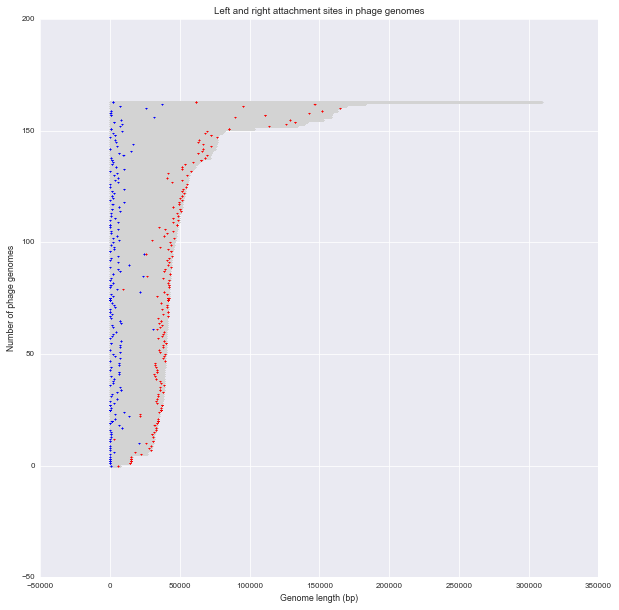

In [7]:
#Going to visualize the attachment sites in phage genomes
#first, let's sort phage genomes based on their length
sortedAtt=mergedAttPhageInfo.sort_values(by=['Genome length (nt)'])
#this part is a filter for genome length, however, I'm really using it since
#all phages are below 400 kb in length
lenBracket=sortedAtt[(sortedAtt['Genome length (nt)']>0) 
                              & (sortedAtt['Genome length (nt)']<400000)].reset_index()
#selecting left attachment sites
left=lenBracket[lenBracket['att']=='attL'].reset_index()
#selecting right attachment sites
right=lenBracket[lenBracket['att']=='attR'].reset_index() 

#plotting
b=plt.figure(figsize=(10,10))
#ax = b.add_subplot(1, 1, 1, axisbg='white')

labelSize = 1
for index, row in left.iterrows():
    #getting genome length from left dataframe
    gl=left.iloc[index]['Genome length (nt)']
    #plotting the genome length
    x=range(0,gl)
    y=[index]*len(x)
    plt.scatter(x,y, s=labelSize, color='lightgray')
    
    #now on top of that plot are the left and right attachment sites
    #obtaining the start site for the left attachment 
    left0=int(left.iloc[index]['loc'][0])
    #obtaining the end site for the left attachment
    left1=int(left.iloc[index]['loc'][1])
    attLeft=range(left0,left1)
    #plotting the left attachment in blue
    plt.scatter(attLeft, [index]*len(attLeft), s=labelSize, color='blue')
    
    #basically the same code as the one for plotting right attachment sites
    right0=int(right.iloc[index]['loc'][0])
    right1=int(right.iloc[index]['loc'][1])
    attRight=range(right0,right1)
    #distinguishing the right attachment by plotting in red
    plt.scatter(attRight, [index]*len(attRight), s=labelSize, color='red')  
plt.title('Left and right attachment sites in phage genomes')
plt.xlabel('Genome length (bp)')
plt.ylabel('Number of phage genomes')

#plt.xlim(-10000)
#plt.ylim(-100)
b.savefig("attOrderedGenomeLength.png",dpi=100 )
plt.show()


###Making a histogram of attachment site lengths

the median length of an attachment site is:  13.0 bp


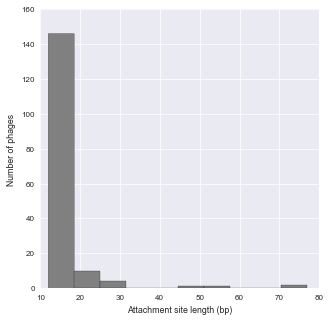

In [20]:
b=plt.figure(figsize=(5,5))
#ax = b.add_subplot(1, 1, 1, axisbg='white')
#plotting the left attachment site length distribution
plt.hist([len(x) for x in lenBracket[lenBracket['att']=='attL']['seq']], color='grey')
#getting the median attachment site length
bmed=np.median([len(x) for x in lenBracket[lenBracket['att']=='attL']['seq']])
print('the median length of an attachment site is: ', bmed, 'bp')
plt.xlabel('Attachment site length (bp)')
plt.ylabel('Number of phages')
b.savefig("attLengthDist.pdf")
plt.show()


#uncomment the following lines to see the same plot for right attachment sites, however, 
#it's basically the same plot
#b= plt.hist([len(x) for x in lenBracket[lenBracket['att']=='attR']['seq']])
#bmed=np.median([len(x) for x in lenBracket[lenBracket['att']=='attL']['seq']])
#print(bmed)
#plt.show()


###Plotting a histogram of attachment site start positions
left attachment site (blue), right (red)

left attachment start position (nt) median value:  1965.5
right attachment start position (nt) median value:  39756.0


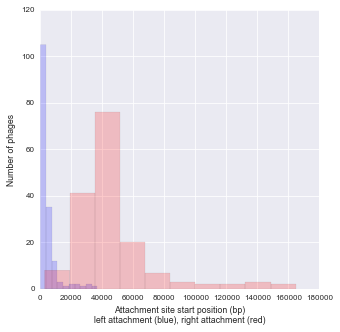

In [10]:
a=plt.figure(figsize=(5,5))
#plotting a histogram of left attachment site start position
plt.hist([int(x[0]) for x in lenBracket[lenBracket['att']=='attL']['loc']], 
         color='blue', alpha=.2)
#plotting a histogram of right attachment site start position
plt.hist([int(x[0]) for x in lenBracket[lenBracket['att']=='attR']['loc']], 
         color='red', alpha=.2)

plt.xlabel('Attachment site start position (bp)'+'\n'+
           'left attachment (blue), right attachment (red)')
plt.ylabel('Number of phages')

print('left attachment start position (nt) median value: ', 
      np.median([int(x[0]) for x in lenBracket[lenBracket['att']=='attL']['loc']]))
print('right attachment start position (nt) median value: ', 
      np.median([int(x[0]) for x in lenBracket[lenBracket['att']=='attR']['loc']]))

plt.show()
a.savefig("attPosDistribution.pdf")

###Plotting a histogram of normalized attachment site start positions 
left attachment site (blue), right (red)

relative start position, left attachment site:  0.0433825284923
relative start position, right attachment site:  0.936287044733


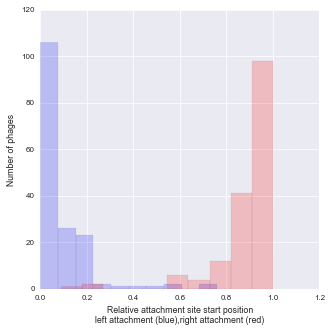

In [12]:
a= plt.figure(figsize=(5,5))
#plotting the left attachment site start position. It is a normalized position because the
#start site position is being normalized by the genome length.

c=lenBracket[lenBracket['att']=='attL']
k=[int(item[0])/c['Genome length (nt)'].iloc[index] for index, item in enumerate(c['loc'])] 
print('relative start position, left attachment site: ', np.median(k))
plt.hist(k, color='blue', alpha=.2)

#plotting the right attachment site start position
t=lenBracket[lenBracket['att']=='attR']
y=[int(item[0])/t['Genome length (nt)'].iloc[index] for index, item in enumerate(t['loc'])] 
print('relative start position, right attachment site: ', np.median(y))
plt.xlabel('Relative attachment site start position'+'\n'+
           'left attachment (blue),right attachment (red)')
plt.ylabel('Number of phages')
plt.hist(y, color='red', alpha=.2)

a.savefig("attRelPosDistribution.pdf")


###Moving on from analyzing attachment site lengths/positions to sequence comparisons

In [23]:
#obtaining the attachment site sequences. Will use Geneious software to do sequence comparison
seqs=lenBracket[lenBracket['att']=='attL'][['acc','seq']]
seqs.head()

,acc,seq
1,NC_001396,GCAGGGGAGGGG
3,NC_002670,AAACTGTCTATTCTATTATAT
5,NC_002669,CAAAAAAACACTGATTGAATGCCGTATG
7,NC_002671,GAAAGACGCAGTTAAATAATTATAGCTAT
8,NC_007045,AAAGAAAGAGGT


###Pairwise percent sequence similarity comparison between phage attachment sites

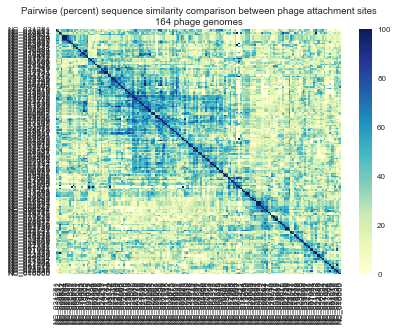

In [15]:
#the pairwise sequence comparison (percent similarity matrix) is uploaded here for visualization
mat=pd.read_csv('attLeftSeqPercentIdentityMatrix.csv', sep=',', index_col=0)
mat=mat.fillna(100)
ax = sns.heatmap(mat, cmap="YlGnBu")
plt.title('Pairwise (percent) sequence similarity comparison between phage attachment sites' 
          + '\n' + '164 phage genomes')
plt.savefig('percentIdentMatrixAttachmentSits.pdf')

###Pairwise sequence similarity comparison (number of shared nucleotides) between phage attachment sites 

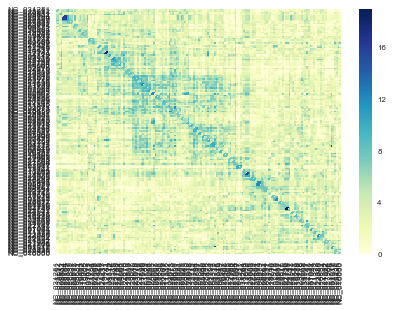

In [196]:
#this is a matrix of the number of shared nucleotides across attachment sites (another view
#of the same data shown in the heatmap above)
mat2=pd.read_csv('attLeftNumIdenSeqsMatrix.csv', sep=',', index_col=0)
ax = sns.heatmap(mat2, cmap="YlGnBu")


###Identifying similar attachment site sequences across different phage genomes

In [327]:
#this bit is written to see which phages have high percentage of similarity between their attachment site sequences, 
#however in order to exclude trivial cases of similarity (those that share a few or even one base pair in 
#the alignment, would still be 100% similar yet share very few bp) another threshold is also 
#employed to ensure that the number of base pairs shared in common is more than half of the 
#number of bases of a median attachment site length (the median is 13 bp)

colL=mat.columns.tolist()
rowL=mat.index.tolist()
#going through each element in the heatmap and getting the row and col names corresponding to 
#values that have similarity beyond a certain threshold. Note we're ignoring 
#diagonal values (hence, x!=y). 
rowCol=[[x,y] for x in rowL for y in colL if (mat[x][y]==100) and (mat2[x][y]>7) and (x!=y)]


#getting rid of duplicate values since there are two copies of the same comparison in any 
#pairwise comparison (above and below the diagonal)
newRowCol=[]
for vec in rowCol:
    if list(reversed(vec)) not in newRowCol:
        newRowCol.append(vec)

#phage pairs (accession numbers) that have similar attachment site sequences
print(newRowCol)

#information regarding each phage in newRowCol can be obtained by placing its accession in the 
#line below
#lenBracket['NC_021789'== lenBracket['acc']]


13
[['NC_028804', 'NC_028784'], ['NC_028804', 'NC_022329'], ['NC_028784', 'NC_022329'], ['NC_019921', 'NC_012784'], ['NC_028764', 'NC_021789'], ['NC_007058', 'NC_003291'], ['NC_013059', 'NC_011976'], ['NC_027393', 'NC_005891'], ['NC_027393', 'NC_005879'], ['NC_005891', 'NC_005879'], ['NC_003315', 'NC_001697'], ['NC_022750', 'NC_004745'], ['NC_022330', 'NC_022085']]


###Plotting attachment sites in genomes (genomes are ordered according to the % sequence similarity heatmap)

/Users/Gita/anaconda/lib/python3.4/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


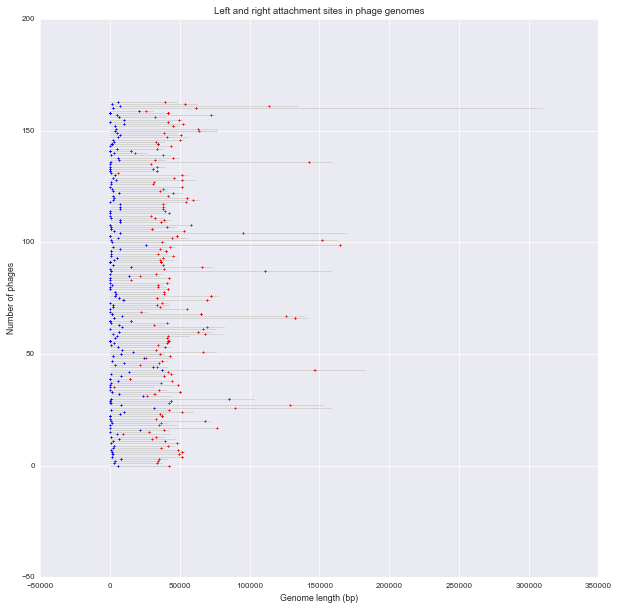

In [16]:
#this plot is showing the attachment sites as before but the genomes are ordered according 
#to the heatmap above. 
accNums=mat.columns.tolist()
accSorted=[]
for num in accNums:    
    for index, row in mergedAttPhageInfo.iterrows():
        if row['acc']== num: 
            accSorted.append(pd.DataFrame(mergedAttPhageInfo.iloc[index]).T)
accSorted = pd.concat(accSorted)

left=accSorted[accSorted['att']=='attL'].reset_index()
right=accSorted[accSorted['att']=='attR'].reset_index() 

p=plt.figure(figsize=(10,10))
#ax = p.add_subplot(1, 1, 1, axisbg='white')
labelSize = 1
for index, row in left.iterrows():
    gl=left.iloc[index]['Genome length (nt)']
    x=range(0,gl)
    y=[index]*len(x)
    plt.scatter(x,y, s=labelSize, color='lightgray', marker='.')
    
    left0=int(left.iloc[index]['loc'][0])
    left1=int(left.iloc[index]['loc'][1])
    attLeft=range(left0,left1)
    plt.scatter(attLeft, [index]*len(attLeft), s=labelSize, color='blue', marker='o')
    
    right0=int(right.iloc[index]['loc'][0])
    right1=int(right.iloc[index]['loc'][1])
    attRight=range(right0,right1)
    plt.scatter(attRight, [index]*len(attRight), s=labelSize, color='red', marker='o')    


plt.xlabel('Genome length (bp)')
plt.ylabel('Number of phages')
plt.title('Left and right attachment sites in phage genomes')
p.show()
p.savefig("attOrderedSeqSimV6.png", dpi=100)
